**Dependencies and setup**

This can take a minute or so...

In [1]:
%%capture
!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'

In [2]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

**Reinforcement learning agent**

Replace this with your own agent - I recommend starting with TD3 (lecture 8)

In [3]:
display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 25 # videos can take a very long time to render so only do it every N episodes

In [4]:
capacity = 2e6
gamma = 0.99
batch_size = 64
tau = 0.005
lr = 5e-4
policy_freq = 2
policy_noise = 0.2
noise_clip = 0.5

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, net_width=256):
        super(Actor, self).__init__()
        self.max_action = max_action
        
        self.l1 = nn.Linear(state_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return torch.tanh(self.l3(a)) * self.max_action

In [6]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, layer_width=256):
        super(Critic, self).__init__()
        self.l1_Q1 = nn.Linear(state_dim + action_dim, layer_width)
        self.l2_Q1 = nn.Linear(layer_width, layer_width)
        self.l3_Q1 = nn.Linear(layer_width, 1)
        self.l1_Q2 = nn.Linear(state_dim + action_dim, layer_width)
        self.l2_Q2 = nn.Linear(layer_width, layer_width)
        self.l3_Q2 = nn.Linear(layer_width, 1)

    def Q1(self, state, action):
        x = torch.cat([state, action], 1)
        q1 = F.relu(self.l1_Q1(x))
        q1 = F.relu(self.l2_Q1(q1))
        q1 = self.l3_Q1(q1)
        return q1

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        q1 = F.relu(self.l1_Q1(x))
        q1 = F.relu(self.l2_Q1(q1))
        q1 = self.l3_Q1(q1)

        q2 = F.relu(self.l1_Q2(x))
        q2 = F.relu(self.l2_Q2(q2))
        q2 = self.l3_Q2(q2)
        return q1, q2

In [7]:
#Based on: https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
class ReplayBuffer(object):
    def __init__(self, max_size=2e5):
        self._storage = []
        self._maxsize = max_size
        self._next_idx = 0

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(np.array(reward, copy=False))
            next_states.append(np.array(next_state, copy=False))
            dones.append(np.array(done, copy=False))
        return np.array(states), np.array(actions), np.array(rewards).reshape(-1, 1), np.array(next_states), np.array(dones).reshape(-1, 1)

In [8]:
%%capture
env = gym.make("BipedalWalker-v3")
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [9]:
class Agent():
    def __init__(self):
        self.actor_primary = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_secondary = Actor(obs_dim, act_dim, max_action, 256).to(device)

        self.actor_target_primary = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_target_secondary = Actor(obs_dim, act_dim, max_action, 256).to(device)
        self.actor_target_primary.load_state_dict(self.actor_primary.state_dict())
        self.actor_target_secondary.load_state_dict(self.actor_secondary.state_dict())

        self.optimizer_actor_primary = torch.optim.Adam(self.actor_primary.parameters(), lr=lr)
        self.optimizer_actor_secondary = torch.optim.Adam(self.actor_secondary.parameters(), lr=lr)

        self.critic_evaluator = Critic(obs_dim, act_dim, 256).to(device)

        self.critic_target = Critic(obs_dim, act_dim, 256).to(device)
        self.critic_target.load_state_dict(self.critic_evaluator.state_dict())

        self.optimizer_critic = torch.optim.Adam(self.critic_evaluator.parameters(), lr=lr)

        self.max_action = max_action

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action_primary = self.actor_primary(state).cpu().data.numpy().flatten()
        action_secondary = self.actor_secondary(state).cpu().data.numpy().flatten()
        action_primary = (action_primary + np.random.normal(0, 0.1, size=act_dim)).clip(-max_action, max_action)
        action_secondary = (action_secondary + np.random.normal(0, 0.1, size=act_dim)).clip(-max_action, max_action)

        q_primary, q_secondary = self.critic_evaluator(state, torch.FloatTensor(action_primary.reshape(1, -1)).to(device))
        q1 = torch.max(q_primary, q_secondary).mean()

        q_primary, q_secondary = self.critic_evaluator(state, torch.FloatTensor(action_secondary.reshape(1, -1)).to(device))
        q2 = torch.max(q_primary, q_secondary).mean()

        if q1 > q2:
            return action_primary
        else:
            return action_secondary

    def train(self, replay_buffer, iterations):
        for it in range(iterations):
            state, action, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            reward = torch.FloatTensor(reward).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).to(device)

            with torch.no_grad():
                noise = torch.randn_like(action).normal_(0, policy_noise).to(device).clamp(-noise_clip, noise_clip)
                next_action_primary = (self.actor_target_primary(next_state) + noise).clamp(-self.max_action, self.max_action)
                next_action_secondary = (self.actor_target_secondary(next_state) + noise).clamp(-self.max_action, self.max_action)

            next_q_primary, next_q_secondary = self.critic_evaluator(next_state, next_action_primary)
            next_q1 = torch.max(next_q_primary, next_q_secondary).mean()

            next_q_primary, next_q_secondary = self.critic_evaluator(next_state, next_action_secondary)
            next_q2 = torch.max(next_q_primary, next_q_secondary).mean()

            next_action = next_action_primary if next_q1 > next_q2 else next_action_secondary

            target_q_primary, target_q_secondary = self.critic_target(next_state, next_action)
            target_q = torch.min(target_q_primary, target_q_secondary)
            target_q = reward + ((1.0 - done) * gamma * target_q).detach()

            current_q_primary, current_q_secondary = self.critic_evaluator(state, action)
            critic_loss = F.mse_loss(current_q_primary, target_q) + F.mse_loss(current_q_secondary, target_q)

            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()

            if it % policy_freq == 0:
                actor_loss_primary = -self.critic_evaluator.Q1(state, self.actor_primary(state)).mean()
                actor_loss_secondary = -self.critic_evaluator.Q1(state, self.actor_secondary(state)).mean()

                self.optimizer_actor_primary.zero_grad()
                actor_loss_primary.backward()
                self.optimizer_actor_primary.step()

                self.optimizer_actor_secondary.zero_grad()
                actor_loss_secondary.backward()
                self.optimizer_actor_secondary.step()

                # Soft update the target networks
                for param, target_param in zip(self.actor_primary.parameters(), self.actor_target_primary.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor_secondary.parameters(), self.actor_target_secondary.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.critic_evaluator.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


**Prepare the environment and wrap it to capture videos**

In [10]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


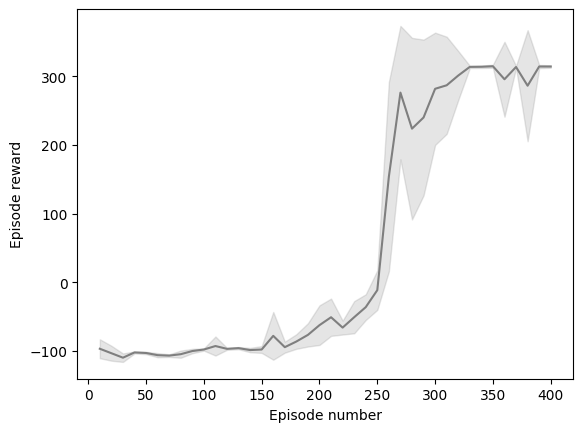

In [11]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)


# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")


# initialise agent
replay_buffer = ReplayBuffer(max_size=capacity)
agent = Agent()
max_episodes = 400
max_timesteps = 2000




# training procedure:
# training procedure:
for episode in range(1, max_episodes + 1):
   state = env.reset()
   ep_reward = 0
   early_exit = False
   for timestep in range(max_timesteps):
       if episode < 20:
           action = env.action_space.sample()  # Explore using random actions
       else:
           action = agent.select_action(state)  # Agent selects action
           action += np.random.normal(0, 0.1, size=action.shape)  # Add exploration noise


       next_state, reward, done, _ = env.step(action)
       ep_reward += reward
       # Adjust reward based on specific game conditions
       if reward == -100:
           reward = -5  # Decrease fall down reward
       else:
           reward *= 5  # Scale other rewards


       # Store transition in the replay buffer
       replay_buffer.add(state, action, reward, next_state, done)
       state = next_state  # Update state to the next state


       # If learning has started, train the agent at each step after initial exploration
       if episode >= 20:
           agent.train(replay_buffer, 1)


       # Check if the episode is finished
       if done or timestep == max_timesteps - 1:
           if episode >= 20:
               agent.train(replay_buffer, timestep)
               
           # Adjust learning rates dynamically if performance is high
           if len(reward_list) > 50 and np.mean(reward_list[-50:]) > 250:
               new_lr = 5e-4 - (5e-4 - 5e-5) * episode / max_episodes
               for optimizer in [agent.optimizer_critic, agent.optimizer_actor_primary, agent.optimizer_actor_secondary]:
                   for param_group in optimizer.param_groups:
                       param_group['lr'] = new_lr
               early_exit = True  # Flag to exit after updating parameters


           if early_exit:
               break  # Stop the current episode if conditions met
           # Ensure no further steps are taken after the episode ends
           break
   reward_list.append(ep_reward)  # Log the accumulated reward for the episode
   
   # do NOT change this logging code - it is used for automated marking!
   log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
   log_f.flush()
   ep_reward = 0


   # print reward data every so often - add a graph like this in your report
   if episode % plot_interval == 0:
       plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
       reward_list = []
       #plt.rcParams['figure.dpi'] = 100
       plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
       plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
       plt.xlabel('Episode number')
       plt.ylabel('Episode reward')
       plt.show()
       disp.clear_output(wait=True)